1249
1026
[1 1 1 ... 0 0 0]
 Constructing training/testing split...
 Training Linear SVM classifier...
 Evaluating classifier on test data ...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       197
           1       1.00      1.00      1.00       258

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

test loss 0
test acc 0
test auc 1
test precision 1
test recall 1


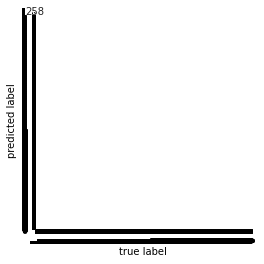

In [10]:
# Importing the necessary modules:
import seaborn as sns
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from skimage.io import imread
import sklearn.externals
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import numpy as np
import argparse
import cv2
import os
import glob
from PIL import Image # This will be used to read/modify images (can be done via OpenCV too)
from numpy import *

# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (16, 16)
cells_per_block = (1, 1)
threshold = .3


# define path to images:

pos_im_path = (r"C:/Users/HP/KTH/jogging_frames") # This is the path of our positive input dataset
# define the same for negatives
neg_im_path= (r"C:/Users/HP/KTH/running_frames")

# read the image files:
pos_im_listing = os.listdir(pos_im_path) # it will read all the files in the positive image path (so all the required images)
neg_im_listing = os.listdir(neg_im_path)
num_pos_samples = size(pos_im_listing) # simply states the total no. of images
num_neg_samples = size(neg_im_listing)
print(num_pos_samples) # prints the number value of the no.of samples in positive dataset
print(num_neg_samples)
data= []
labels = []

# compute HOG features and label them:

for file in pos_im_listing: #this loop enables reading the files in the pos_im_listing variable one by one
    img = Image.open(pos_im_path + '\\' + file) # open the file
    img = img.resize((120,160))
    gray = img.convert('L') # convert the image into single channel i.e. RGB to grayscale
    # calculate HOG for positive features
    fd = hog(gray, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)# fd= feature descriptor
    data.append(fd)
    labels.append(1)
    
# Same for the negative images
for file in neg_im_listing:
    img= Image.open(neg_im_path + '\\' + file)
    #img = img.resize((64,128))
    gray= img.convert('L')
    # Now we calculate the HOG for negative features
    fd = hog(gray, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True) 
    data.append(fd)
    labels.append(0)
# encode the labels, converting them from strings to integers
le = LabelEncoder()
labels = le.fit_transform(labels)
print(labels)
#%%
# Partitioning the data into training and testing splits, using 80%
# of the data for training and the remaining 20% for testing
print(" Constructing training/testing split...")
(trainData, testData, trainLabels, testLabels) = train_test_split(
	np.array(data), labels, test_size=0.20, random_state=42)
#%% Train the linear SVM
print(" Training Linear SVM classifier...")
model = LinearSVC()
history=model.fit(trainData, trainLabels)#history add

#%% Evaluate the classifier
print(" Evaluating classifier on test data ...")
predictions = model.predict(testData)
print(classification_report(testLabels, predictions))


print('test loss', predictions[0])
print('test acc', predictions[1])
print('test auc', predictions[2])
print('test precision', predictions[3])
print('test recall', predictions[4])


# Save the model:
#%% Save the Model
joblib.dump(model, 'model_name.npy')

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(testLabels, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');





In [2]:
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
import sklearn.externals
import joblib
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import numpy as np
import cv2
import os
import glob

#Define HOG Parameters
# change them if necessary to orientations = 8, pixels per cell = (16,16), cells per block to (1,1) for weaker HOG
orientations = 9
pixels_per_cell = (16,16)
cells_per_block = (1, 1)
threshold = .3

# define the sliding window:
def sliding_window(image, stepSize, windowSize):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])
#%%
# Upload the saved svm model:
model = joblib.load("C://model_name.npy")

# Test the trained classifier on an image below!
scale = 0
detections = []
# read the image you want to detect the object in:
img= cv2.imread("C://Users//HP//KTH//boxing_Frames//00001.jpg")

# Try it with image resized if the image is too big
img= cv2.resize(img,(120,160)) # can change the size to default by commenting this code out our put in a random number
cv2.imshow("Original",img)
# defining the size of the sliding window (has to be, same as the size of the image in the training data)
(winW, winH)= (64,128)
windowSize=(winW,winH)
downscale=1.5
# Apply sliding window:
for resized in pyramid_gaussian(img, downscale=1.5): # loop over each layer of the image that you take!
    # loop over the sliding window for each layer of the pyramid
    for (x,y,window) in sliding_window(resized, stepSize=1, windowSize=(winW,winH)):
        # if the window does not meet our desired window size, ignore it!
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        window=color.rgb2gray(window)
        fds = hog(img, orientations, pixels_per_cell, cells_per_block, block_norm='L2')  # extract HOG features from the window captured
        fds = fds.reshape(1, -1) # re shape the image to make a silouhette of hog
        #print(fds)
        pred = model.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window
        
        if pred == 1:
            if model.decision_function(fds) > 0.3:  # set a threshold value for the SVM prediction i.e. only firm the predictions above probability of 0.6
                print("Detection:: Location -> ({}, {})".format(x, y))
                print("Scale ->  {} | Confidence Score {} \n".format(scale,model.decision_function(fds)))
                detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fds),
                                   int(windowSize[0]*(downscale**scale)), # create a list of all the predictions found
                                      int(windowSize[1]*(downscale**scale))))
    scale+=1
    
clone = resized.copy()
for (x_tl, y_tl, _, w, h) in detections:
    cv2.rectangle(img, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 255), thickness = 2)
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) # do nms on the detected bounding boxes
sc = [score[0] for (x, y, score, w, h) in detections]
print("detection confidence score: ", sc)
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)

# the peice of code above creates a raw bounding box prior to using NMS
# the code below creates a bounding box after using nms on the detections
# you can choose which one you want to visualise, as you deem fit... simply use the following function:
# cv2.imshow in this right place (since python is procedural it will go through the code line by line).
        
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(img, (xA, yA), (xB, yB), (0,255,0), 2)
cv2.imshow("Raw Detections after NMS", img)
#### Save the images below
cv2.waitKey(0) & 0xFF 
if k == 27:             #wait for ESC key to exit
    cv2.destroyAllWindows()
elif k == ord('s'):
    cv2.imwrite('C:/Users/HP/KTH/Data',img)
    cv2.destroyAllWindows()



Detection:: Location -> (0, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (1, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (2, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (3, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (4, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (5, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (6, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (7, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (8, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (9, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (10, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (11, 0)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (12, 0)
Scale ->  0 | Confidence Score [0.86699905

Detection:: Location -> (8, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (9, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (10, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (11, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (12, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (13, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (14, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (15, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (16, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (17, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (18, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (19, 2)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (20, 2)
Scale ->  0 | Confidence Score [0.

Detection:: Location -> (18, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (19, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (20, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (21, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (22, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (23, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (24, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (25, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (26, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (27, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (28, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (29, 4)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (30, 4)
Scale ->  0 | Confidence Score [

Detection:: Location -> (24, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (25, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (26, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (27, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (28, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (29, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (30, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (31, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (32, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (33, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (34, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (35, 6)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (36, 6)
Scale ->  0 | Confidence Score [

Detection:: Location -> (32, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (33, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (34, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (35, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (36, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (37, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (38, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (39, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (40, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (41, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (42, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (43, 8)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (44, 8)
Scale ->  0 | Confidence Score [

Detection:: Location -> (34, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (35, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (36, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (37, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (38, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (39, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (40, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (41, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (42, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (43, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (44, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (45, 10)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (46, 10)
Scale ->  0 | Confi

Detection:: Location -> (40, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (41, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (42, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (43, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (44, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (45, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (46, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (47, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (48, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (49, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (50, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (51, 12)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (52, 12)
Scale ->  0 | Confi

Detection:: Location -> (54, 14)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (55, 14)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (56, 14)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (0, 15)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (1, 15)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (2, 15)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (3, 15)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (4, 15)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (5, 15)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (6, 15)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (7, 15)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (8, 15)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (9, 15)
Scale ->  0 | Confidence Scor

Detection:: Location -> (10, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (11, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (12, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (13, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (14, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (15, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (16, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (17, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (18, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (19, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (20, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (21, 17)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (22, 17)
Scale ->  0 | Confi

Detection:: Location -> (22, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (23, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (24, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (25, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (26, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (27, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (28, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (29, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (30, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (31, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (32, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (33, 19)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (34, 19)
Scale ->  0 | Confi

Detection:: Location -> (30, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (31, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (32, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (33, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (34, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (35, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (36, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (37, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (38, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (39, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (40, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (41, 21)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (42, 21)
Scale ->  0 | Confi

Detection:: Location -> (37, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (38, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (39, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (40, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (41, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (42, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (43, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (44, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (45, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (46, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (47, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (48, 23)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (49, 23)
Scale ->  0 | Confi

Detection:: Location -> (40, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (41, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (42, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (43, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (44, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (45, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (46, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (47, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (48, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (49, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (50, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (51, 25)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (52, 25)
Scale ->  0 | Confi

Detection:: Location -> (51, 27)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (52, 27)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (53, 27)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (54, 27)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (55, 27)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (56, 27)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (0, 28)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (1, 28)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (2, 28)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (3, 28)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (4, 28)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (5, 28)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (6, 28)
Scale ->  0 | Confidence S

Detection:: Location -> (0, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (1, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (2, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (3, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (4, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (5, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (6, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (7, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (8, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (9, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (10, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (11, 30)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (12, 30)
Scale ->  0 | Confidence Scor

Detection:: Location -> (50, 31)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (51, 31)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (52, 31)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (53, 31)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (54, 31)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (55, 31)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (56, 31)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (0, 32)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (1, 32)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (2, 32)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (3, 32)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (4, 32)
Scale ->  0 | Confidence Score [0.86699905] 

Detection:: Location -> (5, 32)
Scale ->  0 | Confidence 

NameError: name 'k' is not defined